In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
from datetime import timedelta, date
import time
from yahoo_fin.options import *
import yfinance as yf
from pandas import ExcelWriter
from yahoo_fin import stock_info as si
from arch import arch_model
import math
import random
from scipy.stats import norm
from pandas.plotting import register_matplotlib_converters
import mplfinance as mpf
from numba import jit
from scipy.optimize import minimize
from scipy.optimize import leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
register_matplotlib_converters()
yf.pdr_override()

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import datetime 
from datetime import date
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2  
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(date(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360
S0 = 4180.50#(4185.47 + 4163.26)/2
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM
OPTION EXPIRY DATE,,,,,,,
2021-05-21,0.3571,924.3,931.1,3250.0,6.8,927.70,0.097222
2021-05-21,0.2903,628.0,633.9,3550.0,5.9,630.95,0.097222
2021-05-21,0.3329,824.9,831.7,3350.0,6.8,828.30,0.097222
2021-05-21,0.1582,158.1,161.6,4050.0,3.5,159.85,0.097222
2021-05-21,0.1873,245.1,249.5,3950.0,4.4,247.30,0.097222
...,...,...,...,...,...,...,...
2023-12-15,0.2369,895.0,967.0,3450.0,72.0,931.00,2.702778
2023-12-15,0.2315,825.5,897.5,3550.0,72.0,861.50,2.702778
2023-12-15,0.1902,365.3,413.3,4350.0,48.0,389.30,2.702778


In [23]:
from datetime import date as dat
from scipy.stats import norm
from scipy.optimize import brentq

def implied_volatility(price_ ,S, K, T, r):
    args = [price_,S, K, T, r]
    try:
        res = brentq(Optimisor,0.0001,1000,args,maxiter=10000)
    except :
        res = np.nan
    return res

def _price_(S, K, T, r, v):
    d1 = (np.log(S/K) + (r + 0.5 * v ** 2) * T)/(v * T**(1/2))
    d2 = d1 - v * T **(1/2)
    Option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Option_price

def Optimisor(x,args):
    price_,S, K, T, r = args
    A = _price_(S, K, T, r, x)
    MNM = A - price_
    return MNM


In [26]:
def Local_Vola_surface(S, K,TTM, drift,v):
    
    dt,dK = 1e-3,1e-3
    
    C_KK = (_price_(S, K+dK, TTM, drift, v) - 2 * _price_(S, K, TTM, drift, v)  +\
            _price_(S, K-dK, TTM, drift, v))/(dK**2)
    
    C_t = (_price_(S, K, TTM+dt, drift, v) - _price_(S, K, TTM-dt, drift, v))/(2*dt)
    
    C_K = (_price_(S, K+dK, TTM, drift, v) - _price_(S, K-dK, TTM, drift, v))/(2*dK)
    
    C = _price_(S, K, TTM, drift, v)
    
    Local_vol = np.sqrt(2*(C_t +  drift *  K * C_K  + 0.03/100 * C )/((K**2)*C_KK))

    return Local_vol

In [41]:
IV,LV = {},{}
r = 0.03/100
q = 1.45/100
drift = r-q
for i in range(0,len(L)):
    IVO   = implied_volatility(L['Mid Price'].iloc[i],4180.50,L['Strikes'].iloc[i],L['TTM'].iloc[i],drift)
    IV[i] = IVO
    LV[i] = Local_Vola_surface(4180.50, L['Strikes'].iloc[i],L['TTM'].iloc[i], drift,IVO)

In [42]:
L['ImpliedVola'] = IV.values()
imp_vol = IV.values
spreads = L.Spread.values
L['Local Volatility'] = LV.values()
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM,ImpliedVola,Gamma,Local Volatility
OPTION EXPIRY DATE,,,,,,,,,,
2021-05-21,0.3571,924.3,931.1,3250.0,6.8,927.70,0.097222,0.355634,0.000059,0.357637
2021-05-21,0.2903,628.0,633.9,3550.0,5.9,630.95,0.097222,0.292970,0.000199,0.293345
2021-05-21,0.3329,824.9,831.7,3350.0,6.8,828.30,0.097222,0.333990,0.000088,0.336650
2021-05-21,0.1582,158.1,161.6,4050.0,3.5,159.85,0.097222,0.161763,0.001555,0.161791
2021-05-21,0.1873,245.1,249.5,3950.0,4.4,247.30,0.097222,0.188591,0.001013,0.188583
...,...,...,...,...,...,...,...,...,...,...
2023-12-15,0.2369,895.0,967.0,3450.0,72.0,931.00,2.702778,0.231848,0.000210,0.231791
2023-12-15,0.2315,825.5,897.5,3550.0,72.0,861.50,2.702778,0.227535,0.000223,0.227669
2023-12-15,0.1902,365.3,413.3,4350.0,48.0,389.30,2.702778,0.190943,0.000303,0.191186


In [43]:
def Gamma_compilator(S,K,vol,dt,drift):
    d1 = (np.log(S/K) + (r - q + .5 * vol**2 )*dt)/(vol*np.sqrt(dt))
    Gamma = norm.pdf(d1)/(S*vol*np.sqrt(dt))
    return Gamma 

In [44]:
L['Gamma'] = Gamma_compilator(S0,L.Strikes.values,L['ImpliedVola'].values,L.TTM.values,drift)
Q = L.groupby(['TTM','Strikes']).mean()

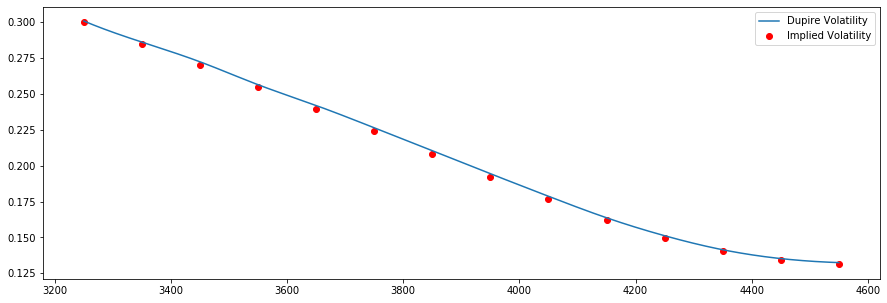

In [53]:
from scipy.interpolate import interp1d
t = L.TTM.unique()[3]
Concerned = Q.loc[t]
stk = Q.loc[t].index
LV = Concerned['Local Volatility'].values
IVol = Q.loc[t]['IV'].values
f = interp1d(stk, LV,kind='cubic')
x = np.linspace(np.min(stk), np.max(stk),1000, endpoint=True)
fig = plt.figure(figsize=(15,5))
plt.plot(x,f(x))
plt.scatter(stk,IVol,color = 'red')
plt.legend(['Dupire Volatility','Implied Volatility'])
plt.show()

# Surfaces Using Gaussian Process

In [54]:
# The training set
from itertools import product
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")

def Gaussian_Process_Interpolator(Strikes,TTM,Volatility,noise_variance,word,plot = 'Yes'):
    
    strkm = Strikes.reshape(len(Strikes),1)
    ttmm = TTM.reshape(len(TTM),1)
    X =  np.hstack((strkm,ttmm))
    Y = Volatility.reshape(len(Volatility),1)
    x,y = np.linspace(np.min(strkm),np.max(strkm),100),np.linspace(np.min(ttmm),np.max(ttmm),100)
    X,Y,Z,MSE = sk_sim(X,Y,noise_variance,x,y)
    if plot == 'Yes' : 
        Plotting(X,Y,Z,MSE)
    else :
        return X,Y,Z
    
    
def sk_sim(X,Y,noise_variance,x1,x2):
    kernel = C(0.0, (1e-3, 1e3)) + RBF([1,1]) + WhiteKernel(noise_level = noise_variance)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
    gp.fit(X, Y)
    x1x2 = np.array(list(product(x1, x2)))
    y_pred = gp.predict(x1x2,return_std=False)
    y_pred2, sigma = gp.predict(X,return_std=True)
    MSE = np.mean((y_pred2 - Y)**2)
    X0p,X1p,Zp = getReshapeNZ(x1x2,y_pred)
    return X0p,X1p,Zp,MSE
    
def getReshapeNZ(S,y_pred):
    N = int(np.sqrt(len(S)))
    X0p, X1p = S[:,0].reshape(N,N), S[:,1].reshape(N,N)
    Zp = np.reshape(y_pred,(N,N))
    return X0p,X1p,Zp

def Plotting(X,Y,Z,MSE):
    fig = plt.figure(figsize=(25, 15))
    ax1 = fig.add_subplot(projection='3d')       
    surf = ax1.plot_surface(X, Y, Z,rstride=1, cstride=1,cmap='jet', alpha=0.5)
    ax1.set_xlabel('Strikes')
    ax1.set_ylabel('Time to Maturity')
    plt.title(r'Interpolation  $MSE$ = {}'.format(MSE.round(6)),fontsize=15)

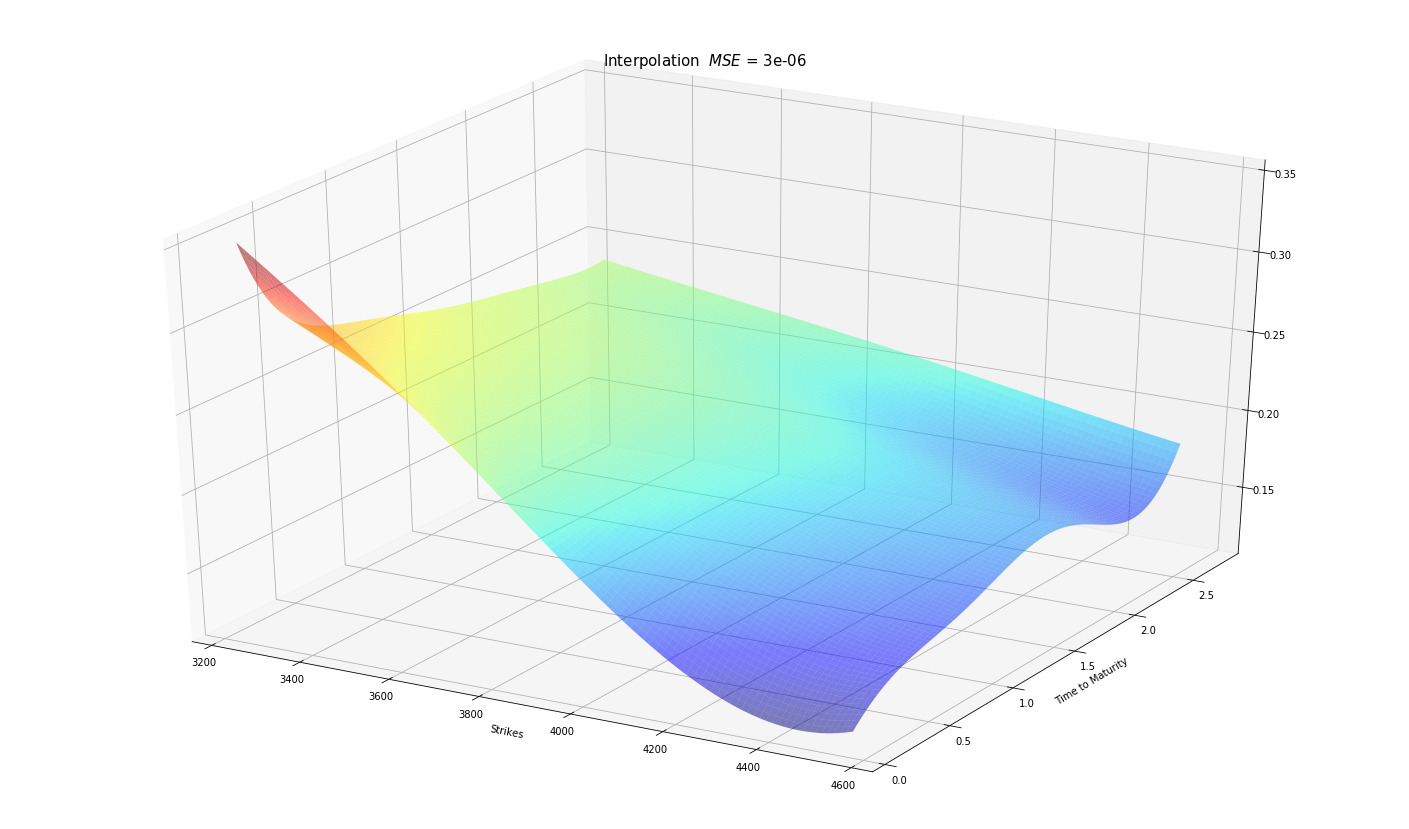

In [55]:
strik = L['Strikes'].values
TTMs = L['TTM'].values
IV = L['ImpliedVola'].values
Gaussian_Process_Interpolator(strik,TTMs,IV,1,'Implied Volatility')

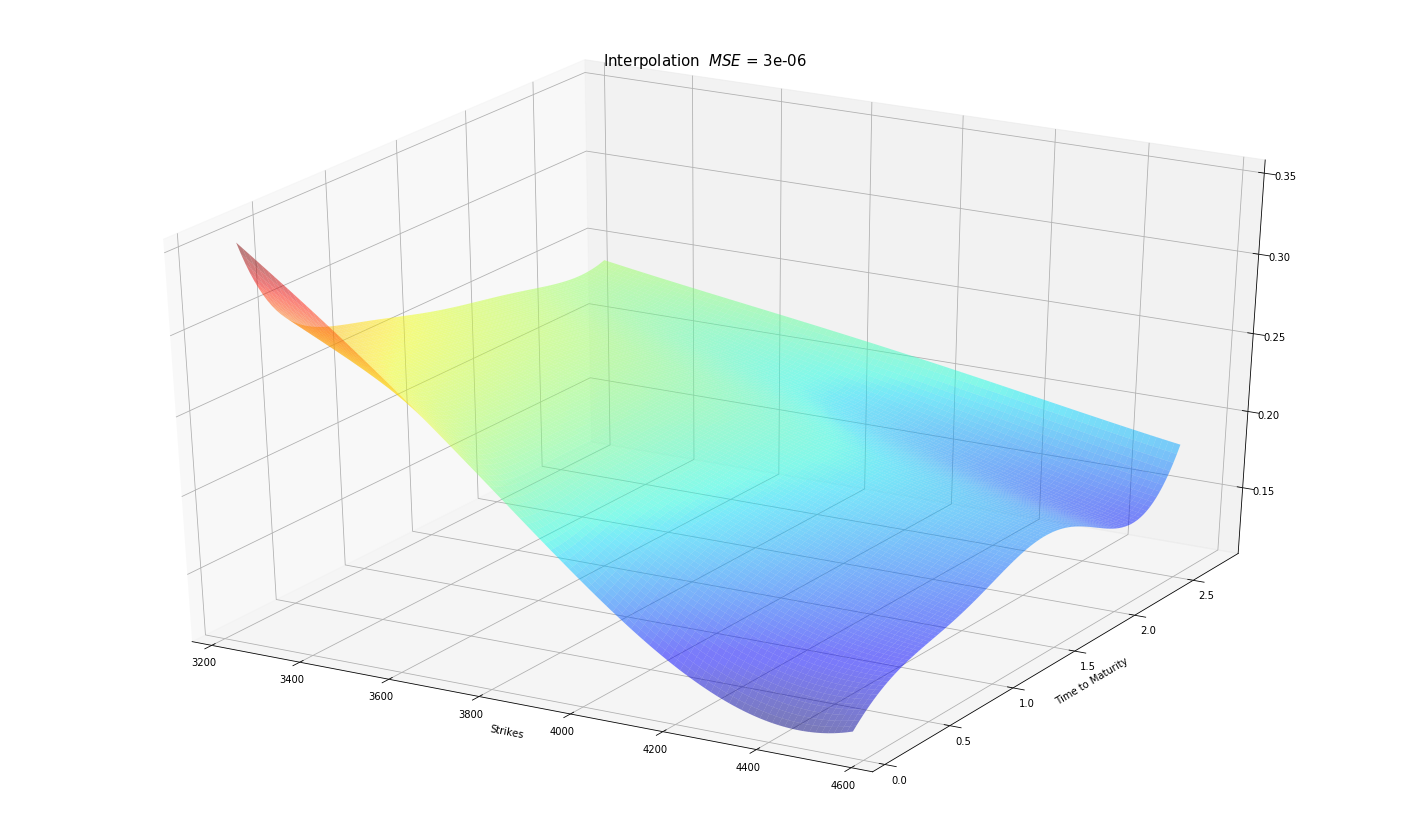

In [56]:
strik = np.array(Q.droplevel(0).index)
TTMs =  np.array(Q.droplevel(1).index)
LVol = Q['Local Volatility'].values
Gaussian_Process_Interpolator(strik,TTMs,LVol,1,'Local Volatility')

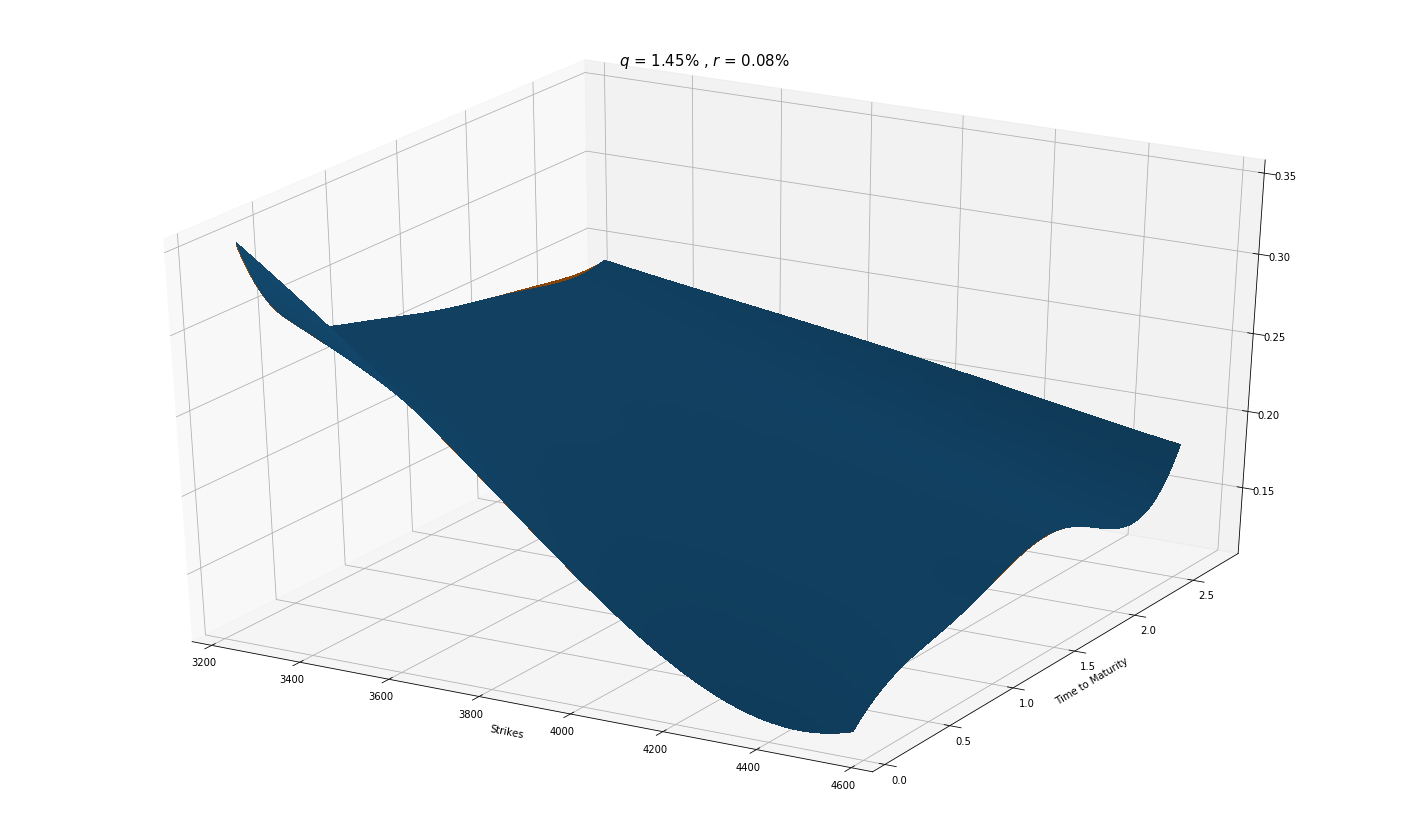

In [57]:
#The Surface Fit is quasi-perfect

strik = np.array(Q.droplevel(0).index)
TTMs =  np.array(Q.droplevel(1).index)
LVol = Q['Local Volatility'].values
IV = Q['ImpliedVola'].values
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(projection='3d')
X1,Y1,Z1 = Gaussian_Process_Interpolator(strik,TTMs,LVol,1,'Local Volatility','No')
X2,Y2,Z2 = Gaussian_Process_Interpolator(strik,TTMs,IV,1,'Implied Volatility','No')
c1 = ax.plot_surface(X1,Y1,Z1,cstride=1, rstride=1, linewidth=1, antialiased=False, alpha=1)
c2 = ax.plot_surface(X2,Y2,Z2,cstride=1, rstride=1, linewidth=1, antialiased=False, alpha=1)
ax.set_xlabel('Strikes')
ax.set_ylabel('Time to Maturity')
#plt.legend(['Local Volatility','Implied Volatility'])
plt.title(r'$q$ = 1.45% , $r$ = 0.08%',fontsize=15)
plt.show()

# Gamma

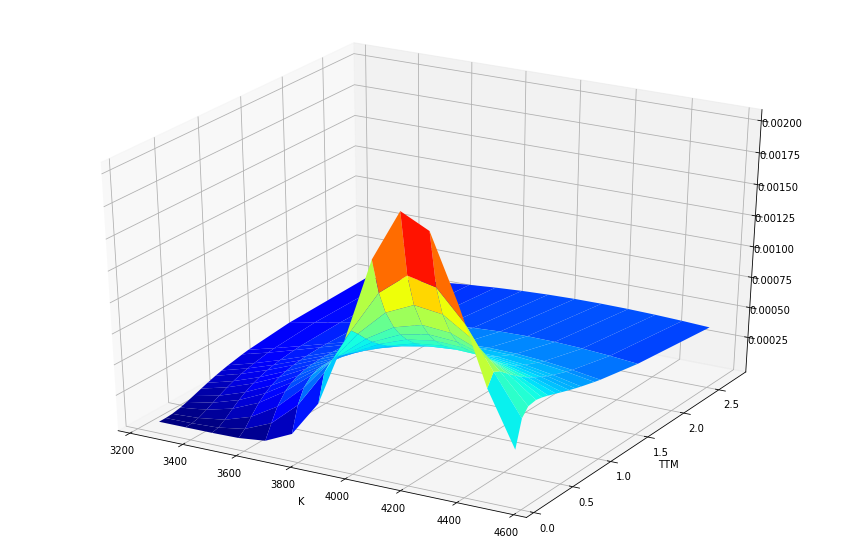

In [58]:
# Creates a 1D array of all possible x and y coordinates
x_coords = L['Strikes'].sort_values().values
y_coords = L['TTM'].sort_values().values

# Creates 2D array with all possible combinations of x and y coordinates,
# so x_grid.shape = (100, 100) and y_grid.shape = (100, 100)
[x_grid, y_grid] = np.meshgrid(x_coords, y_coords)

# Evaluates z at all grid points (S,K,Realized_sigma,dt,r)
z_grid = Gamma_compilator(S0,x_coords,0.148,y_grid,drift)

# Plotting
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid,y_grid,z_grid,cmap='jet')
#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('K')
plt.ylabel('TTM')
plt.show()